In [1]:
import pandas as pd
import numpy as np
import os
import random
from datetime import datetime
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.family'] = 'Meiryo'
import glob
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision import transforms
import torchvision
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models.resnet import ResNet,Bottleneck,BasicBlock

In [2]:
test_fn = r'./dataset_cur_test.csv'
new_dir_path_recursive = './myResnet18C/'

In [3]:
def plot_graph(values1, values2, rng, label1, label2):
    plt.subplots (1,1,figsize=(4,3))
    plt.plot(range(rng), values1, label=label1)
    plt.plot(range(rng), values2, label=label2)
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
tdf = pd.read_csv(new_dir_path_recursive+'mynet_spec.csv',index_col=0)
tdf.head(2)

,train_loss_values,train_accuracy_values,valid_loss_values,valid_accuracy_values
0,0.134148,0.259482,0.062879,0.305045
1,0.552815,0.249373,0.065191,0.257267


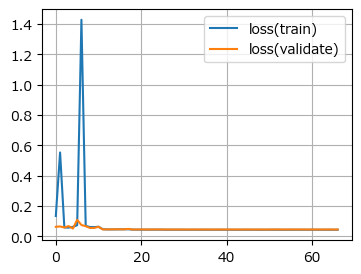

In [5]:
plot_graph(tdf['train_loss_values'], tdf['valid_loss_values'],len(tdf), 'loss(train)', 'loss(validate)')

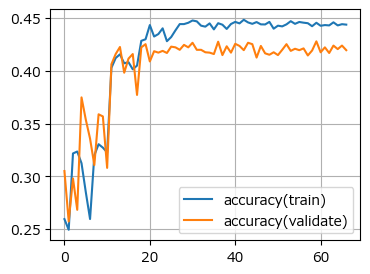

In [6]:
plot_graph(tdf['train_accuracy_values'], tdf['valid_accuracy_values'],len(tdf),  'accuracy(train)', 'accuracy(validate)')

In [7]:
test_fn = r'./dataset_cur_test.csv'
test_fn

'./dataset_cur_test.csv'

In [8]:
df_test = pd.read_csv(test_fn,index_col=0)
df_test = df_test.reset_index(drop=True)
df_test['red_diff'] = df_test['red_diff'].astype(np.float32)
df_test['remain_ends'] = df_test['remain_ends'].astype(np.float32)
df_test['last_stone_is_red'] = df_test['last_stone_is_red'].astype(np.float32)
df_test['red_postion'] = df_test['red_postion'].astype(np.float32)
display(df_test.dtypes)
display(df_test.head(3))

redpoint_-3            int64
redpoint_-2            int64
redpoint_-1            int64
redpoint_0             int64
redpoint_1             int64
redpoint_2             int64
redpoint_3             int64
pred                   int64
ends                   int64
red                  float64
yellow               float64
red_diff             float32
remain_ends          float32
last_stone_is_red    float32
red_postion          float32
filepath              object
page                   int64
T                     object
dtype: object

,redpoint_-3,redpoint_-2,redpoint_-1,redpoint_0,redpoint_1,redpoint_2,redpoint_3,pred,ends,red,yellow,red_diff,remain_ends,last_stone_is_red,red_postion,filepath,page,T
0,0,0,0,0,0,1,0,2,5,2.0,0.0,2.0,4.0,1.0,-4.0,./dataset_o\WWCC2023_ResultsBook\geme524end5.png,524,WWCC2023_ResultsBook
1,0,0,0,1,0,0,0,0,8,0.0,0.0,0.0,1.0,1.0,3.0,./dataset_o\WMCC2022_ResultsBook\geme694end8.png,694,WMCC2022_ResultsBook
2,0,0,0,0,1,0,0,1,6,1.0,0.0,1.0,3.0,0.0,0.0,./dataset_o\OWG2018_ResultsBook\geme526end6.png,526,OWG2018_ResultsBook


In [9]:
# 標準化
_stdsc = StandardScaler()
##学習時の標準化したパラメータは、評価、本番時におなじ重みで標準化する処理が必要
sc = pickle.load(open(new_dir_path_recursive+'stdsc_02240209.pkl', "rb"))

##学習時の標準化したパラメータは、評価、本番時におなじ重みで標準化する処理が必要
x_test_df  = df_test[['remain_ends','last_stone_is_red','red_postion']].copy()
x_test_std = sc.transform(x_test_df)
display( x_test_std[:3] )
display(sc.n_features_in_, sc.mean_ , sc.var_) 
df_test[['remain_ends','last_stone_is_red','red_postion']] = x_test_std
df_test.head(5)

array([[-0.0171741 ,  0.99846405, -1.6831093 ],
       [-1.1712582 ,  0.99846405,  1.2369138 ],
       [-0.40186876, -1.0015383 , -0.0145247 ]], dtype=float32)

3

array([4.04464345, 0.50076856, 0.03481922])

array([6.757213  , 0.24999941, 5.74676597])

,redpoint_-3,redpoint_-2,redpoint_-1,redpoint_0,redpoint_1,redpoint_2,redpoint_3,pred,ends,red,yellow,red_diff,remain_ends,last_stone_is_red,red_postion,filepath,page,T
0,0,0,0,0,0,1,0,2,5,2.0,0.0,2.0,-0.017174,0.998464,-1.683109,./dataset_o\WWCC2023_ResultsBook\geme524end5.png,524,WWCC2023_ResultsBook
1,0,0,0,1,0,0,0,0,8,0.0,0.0,0.0,-1.171258,0.998464,1.236914,./dataset_o\WMCC2022_ResultsBook\geme694end8.png,694,WMCC2022_ResultsBook
2,0,0,0,0,1,0,0,1,6,1.0,0.0,1.0,-0.401869,-1.001538,-0.014525,./dataset_o\OWG2018_ResultsBook\geme526end6.png,526,OWG2018_ResultsBook
3,0,0,0,0,1,0,0,1,4,1.0,0.0,1.0,0.367521,-1.001538,-0.431671,./dataset_o\OWG2018_ResultsBook\geme201end4.png,201,OWG2018_ResultsBook
4,0,1,0,0,0,0,0,-2,9,0.0,2.0,-2.0,-1.555953,-1.001538,-0.014525,./dataset_o\WMCC2023_ResultsBook\geme536end9.png,536,WMCC2023_ResultsBook


In [10]:
class ImgValueDataset(Dataset):
    def __init__(self, df, classcol , fncol ,extendcol, transform):
        
        self.img_pathlist = df[fncol].values
        
        class_data = df[classcol].values
        self.label_list  = class_data.astype(float)
        
        self.val_list  = df[extendcol].astype(np.float16).values
        self.transform = transform

    def __len__(self):  
        return len( self.img_pathlist )
    
    def __getitem__(self, index):
        # 画像をPILとして読み込む
        #print(index,self.img_pathlist[index])
        image = Image.open(self.img_pathlist[index])
        
        label = self.label_list[index]

        extend = self.val_list[index]                         
        if self.transform is not None:
            ##print('use transform')
            image = self.transform(image)
        ## 次元を足してやってっそこに追加データをぶっこむ
        extend_tensor = np.full((224,224),255)
        extend_tensor[1][0] = extend[0]
        extend_tensor[1][1] = extend[1]
        extend_tensor[1][2] = extend[2]
        #print(extend_tensor)
        extend_tensor = torch.Tensor(extend_tensor)
        extend_tensor = extend_tensor.unsqueeze(0)
        out = torch.cat([image, extend_tensor], dim=0)
                             
        return out, label 
    pass

In [11]:
# CNNモデルの定義
class myResnet18(models.resnet.ResNet):
    def __init__(self, block,layers,num_classes):
        super().__init__(block,layers,num_classes)
        

        pass
    
    def forward(self, xpacked:torch.Tensor) -> torch.Tensor:
        input = xpacked
        #print('input:',input.shape)
        x = input[:,:3]
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        ###########################################
        params = input[:,3,1,0:3]
        output = torch.cat([x,params],1)
        
        ###########################################
        output = self.fc(output)

        return output

In [12]:
## ベストモデル
fn = new_dir_path_recursive + 'checkpoint_model.pth'
os.path.exists(fn),fn

(True, './myResnet18C/checkpoint_model.pth')

In [13]:
labels_cols = list(filter( lambda s:s.startswith('redpoint_'),  df_test.columns))
display(labels_cols , df_test[labels_cols][:2])

['redpoint_-3',
 'redpoint_-2',
 'redpoint_-1',
 'redpoint_0',
 'redpoint_1',
 'redpoint_2',
 'redpoint_3']

,redpoint_-3,redpoint_-2,redpoint_-1,redpoint_0,redpoint_1,redpoint_2,redpoint_3
0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0


In [14]:
extend_cols = ['remain_ends','last_stone_is_red','red_postion']
extend_cols

['remain_ends', 'last_stone_is_red', 'red_postion']

In [15]:
model_from_script = torch.load(fn, map_location="cuda")
print(type(model_from_script))
net2 = net = myResnet18(block=BasicBlock,layers=[2, 2, 2, 2],num_classes=1000)
num_class = len(labels_cols)
## 最終を置き換える
num_ftrs = net.fc.in_features
net2.fc = nn.Sequential(
    nn.Linear(num_ftrs+3, 1024),
##        nn.ReLU(inplace=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1024, len(labels_cols)),
)
net2.load_state_dict(torch.load(fn))

<class 'collections.OrderedDict'>


<All keys matched successfully>

In [16]:
%%time
target_size = 224
transform_test = transforms.Compose([
    transforms.Pad(( 240 // 2, 0), fill=0, padding_mode='constant'),  # 左右に余白を追加
    transforms.Resize(target_size),
    transforms.CenterCrop(target_size),
    transforms.RandomHorizontalFlip(0.33),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 128

q_test = ImgValueDataset( df_test ,classcol=labels_cols , fncol='filepath',extendcol = extend_cols  ,transform=transform_test)
q_loader = DataLoader(q_test, batch_size=batch_size, shuffle=False, num_workers=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
gpu_model = net2.to(device)
y_list = [] 
t_list = []
lable_list = []
with torch.no_grad():
    accs = [] # 各バッチごとの結果格納用
    for batch in q_loader:
        x, label = batch
        x = x.to(device)
        t = label.to(device)
        y = gpu_model(x)
        
        y_label = torch.argmax(y, dim=1)
        t_label = torch.argmax(t, dim=1)
        acc = torch.sum(y_label == t_label) * 1.0 / len(t)
        accs.append(acc)
        y_list.extend(y_label.to("cpu").numpy())
        t_list.extend(t_label.to("cpu").numpy())       
    

CPU times: total: 4min 13s
Wall time: 1min 47s


In [17]:
np.mean( list(map( lambda r:r.item() ,accs )) )

0.42337503800025356

In [18]:
from sklearn.metrics import confusion_matrix
val_mat = confusion_matrix(y_list, t_list, labels=np.unique(t_list))

In [19]:
val_mat

array([[ 15,  10,   8,   0,   4,   0,   0],
       [ 27,  55,  35,   9,  23,   3,   0],
       [ 25,  86, 197,  27,  84,  34,  19],
       [  8,  31,  56, 127,  46,  15,   2],
       [ 16,  37,  71,  36, 199,  77,  24],
       [  2,   5,  28,   2,  48,  94,  30],
       [  0,   2,   7,   0,  10,  12,  17]], dtype=int64)

In [20]:
pd.DataFrame(val_mat,index=labels_cols,columns=labels_cols)

,redpoint_-3,redpoint_-2,redpoint_-1,redpoint_0,redpoint_1,redpoint_2,redpoint_3
redpoint_-3,15,10,8,0,4,0,0
redpoint_-2,27,55,35,9,23,3,0
redpoint_-1,25,86,197,27,84,34,19
redpoint_0,8,31,56,127,46,15,2
redpoint_1,16,37,71,36,199,77,24
redpoint_2,2,5,28,2,48,94,30
redpoint_3,0,2,7,0,10,12,17


In [21]:
k = pd.DataFrame(df_test['pred'])

In [22]:
k['t_label'] =  t_list
k['y_label'] =  y_list


In [23]:
(k['pred'] - k['t_label']).unique()

array([-3], dtype=int64)

In [24]:
df_test['dl_pred'] = y_list
df_test['dl_pred'] = df_test['dl_pred']-3

In [25]:
df_test.loc[df_test['dl_pred']==df_test['pred']].shape

(704, 19)

In [26]:
df_test.shape

(1663, 19)